# ML model for Data Delivery Mode Filter - Tech Notebook
This notebook introduces (1) identify the research question, (2) justify the selection of the ML model, (3) explore, prepare and preprocess the datasets; (4) how to train and evaluate the ML model; and (5) how to use this trained ML model, for technical audiences.
## Problem Description
The AOND catalougue $C=\{M, K, F_D \}$ serves as a platform for discovering datasets and their associated metadata. Particularly:
- $M=\{m_1,m_2,\ldots, m_x\}$ is the set of metadata records that describe the datasets in the AODN catalogue $C$.
- $K$ represents the pre-defined keywords used to categorise these datasets.
- $F_D$ (see Definition 4) is the data delivery mode filter which used for filtering datasets with distinctive data delivery mode.

### Formal Definitions

- **Definition 1: A Metadata Record $m_i \in M$** is defined as a tuple $m_i = (t_i, d_i, K_i, l_i, s_i, f_i)$, where:  
- $i$: A unique identifier for the metadata record.  
- $t_i$: The **title**, a textual summary of the dataset.  
- $d_i$: The **abstract**, a textual description of the dataset.  
- $K_i \subseteq K$: A set of **keywords** associated with the dataset (see **Definition 2**).  
- $l_i$: A textual statement representing the **lineage** of the dataset.  
- $s_i$: The **status** of the dataset, as defined in **Definition 3**.  
- $f_i \in F_D$: The **data delivery mode** of the dataset (see **Definition 4**).

The vector representation $\mathbf{m_i}$ of a metadata record $m_i$ is calculated as the embedding of its combined textual fields. Depending on the task:  
- For **keyword classification**, only the title $t_i$ and abstract $d_i$ are used.  
- For **data delivery mode classification**, the title $t_i$, abstract $d_i$, and lineage $s_i$ are considered.  

The embeddings are generated using the "bert-base-uncased" model, and each record has a universal dimensionality, denoted as $\text{dim} = |\mathbf{d_i}|$.  

A feature matrix $\mathbf{X} $ is the input of the classification models. $\mathbf{X} \in \mathbb{R}^{|M_s| \times \text{dim}}$ aggregates the embeddings of all records in $M_s$, where $|M_s|$ is the total number of metadata records. 

- **Definition 2: A Keyword $k_j$** is a predefined label used for catogarising datasets. Each metadata record $m_i$ is associated with a set of keywords $K_i \subseteq K$, while $K$ is the complete set of predefined keywords. The keywords $K_i$ for a metadata record $m_i$ is mathematiacally represented as a binary vector $y_i$ with a size of $|K|$. where each element indicates the presence or absence of a specific label. A value of 1 at position $j$ denotes the label $k_j \in K$ is present in the metadata record $m_i$, in this sence $k_j \in K_i$, while a value of 0 indicates its absence. A target matrix $\mathbf{Y}$ is a $|M_s| \times |K|$ binary matrix, where $|M_s|$ is the size of the metadata records set $M_s=\{m_1,m_2,\ldots, m_x\}$, and $|K|$ is the size of the keywords set $K=\{k_1, k_2, \ldots, k_y\}$. Each entry $ \mathbf{K}[i, j] $ is 1 if metadata record $ m_i $ is associated with keyword $ k_j $, and 0 otherwise.

The target matrix $\mathbf{Y} $ is the output of the *keyword classification model*. $\mathbf{Y} \in \{0, 1\}^{|M_s| \times |K|}$ aggregates all binary vectors for the metadata set $M_s$, where:  
- $|M_s|$: Total number of metadata records.  
- $|K|$: Total number of keywords.  

Each entry $\mathbf{Y}[i, j]$ is $1$ if record $m_i$ is associated with keyword $k_j$, and $0$ otherwise.

- **Definition 3: The Status $s_i$** is textual information denoting the state of a dataset. It can take one of three possible values: $u_i \in \{\text{Completed, Ongoing, Others}\}.$

- **Definition 4: Data Delivery Mode Filter $F_D$** is the set of inferred data delivery modes with four potential values: $F_D = \{\text{Completed, Real-Time, Delayed, Other}\}$. 
<!-- TODO: REFINE THIS DEFINITION -->
A metadata record $m_i$ is mapped with a data delivery mode value with the considation of its status $s_i$, and 
A dataset is inferred with a data delivery mode through the textual information from the fields title $t_i$, abstract $d_i$, and lineage $l_i$ within its metadata record $m_i$.

The mapping of a dataset's status to a delivery mode follows these rules:  
1. If the status $s_i$ is "Completed," it is mapped to $f_i$ **Completed**.
2. If the status $s_i$ is "Ongoing," further analysis determines the mapping as either **Real-Time** or **Delayed**.   
3. If the status $s_i$ is neither "Completed" nor "Ongoing," it is mapped to **Other**.

### Problem Description:
In the catalog $C=\{M, K, F_D \}$, the **data delivery mode filter F_D** is used to search for and filter datasets based on specific delivery modes from four options: $\{Completed, Real-Time, Delayed, Other\}$. Normaly, the "Completed" and "Others" modes are straightforward to identify as they align directly with the metadata record's status field. However, for records marked with an "Ongoing" status, classification becomes ambiguous, especially for non-IMOS datasets. For IMOS datasets, a clear rule exists: titles contain keywords like "Real-Time" (or its variants) and "Delayed" (or its variants), which can be directly used for classification.

For non-IMOS datasets with an "Ongoing" status, the classification logic cannot rely on such title-based rules. Current approaches, such as if-else decision trees, fail to generalise due to the volume of ambiguous records (as discussed in the [GitHub issue](https://github.com/aodn/backlog/issues/6148)).

To address this, the task is framed as a **text classification** task focus on non-IMOS datasets with an "Ongoing" status. The input is the combied textual features, including the metadata records' title $t_i$, abstract $d_i$, and lineage $s_i$. The output is the data delivery mode as either "Real-Time" or "Delayed". The goal is to develop a machine learning (ML) model capable of learning a mapping rule between the textual content of metadata records and the appropriate data delivery mode as "Real-Time" or "Delayed".

In [1]:
# add module path for notebook to use
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(project_root)

# import customised modules
import data_discovery_ai.utils.preprocessor as preprocessor
import data_discovery_ai.common.constants as constants
import data_discovery_ai.utils.es_connector as es_connector

c:\Users\yhu12\AppData\Local\miniforge3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preprocessing
In this section, we preprocess the data to prepare it as input for an ML model. Three textual fields are filtered and combined together as the textual information of a metadata record $m_i$. These fields are: the title $t_i$, the abstract $d_i$, and the lineage $l_i$. These texts are concatenated together and treated as a single piece of information. A transformer model, BERT, is then applied to this text to compute the embeddings of the textual information.

-----------

In [2]:
ddm_resource_folder = constants.FILTER_FOLDER
ddm_resource_file = constants.FILTER_PREPROCESSED_FILE
filter_preprocessed_data = preprocessor.load_from_file(f"../data_discovery_ai/resources/{ddm_resource_folder}/{ddm_resource_file}")
filter_preprocessed_data

,id,title,abstract,lineage,status,information,embedding
1,0024b456-4636-42cd-b097-388f6d39a835,WAMSI Node 4.2.3 - Fisheries dependent data an...,"From 1990, continuous (15-minute, 30-minute or...","a) 1990 to 1994: Wesdata models 886, 187, 389;...",onGoing,WAMSI Node 4.2.3 - Fisheries dependent data an...,"[-1.2472235, -0.52754223, 0.08079154, -0.50992..."
12,006bb7dc-860b-4b89-bf4c-6bd930bd35b7,IMOS - ANMN National Reference Stations - Darw...,This collection includes observations transmit...,NATIONAL REFERENCE STATIONS The IMOS national ...,onGoing,IMOS - ANMN National Reference Stations - Darw...,"[-0.91694874, -0.2440666, 0.26462442, -0.03149..."
16,0094682a-e438-41e8-a39b-19cf2093025d,Thursday Island Wind From 08 Feb 2012,This data set was collected by weather sensors...,Data from AIMS weather stations are subjected ...,onGoing,Thursday Island Wind From 08 Feb 2012 [SEP] Th...,"[-1.0509518, -0.55623543, 0.2895106, -0.310500..."
24,00d34cd4-24fe-4361-b667-1782c919e870,Coastal Infrastructure Points,Spatial representation of Department of Transp...,Features sourced from DOT Asset Management dat...,onGoing,Coastal Infrastructure Points [SEP] Spatial re...,"[-0.96098024, -0.38567236, 0.054584935, -0.344..."
37,0155375c-8070-4662-9c93-b593ee4891b0,Davies Reef Water Temperature From 18 Oct 1991,The 'Wireless Sensor Networks Facility' (forme...,All sensors are factory calibrated and then ca...,onGoing,Davies Reef Water Temperature From 18 Oct 1991...,"[-0.8229743, -0.26159173, 0.58714104, -0.04611..."
...,...,...,...,...,...,...,...
12891,svenner_penguin_gis,Svenner Islands penguin GIS dataset,Aerial photography (Linhof) of penguin colonie...,TOPIC: Planimetric accuracy of penguin colony ...,onGoing,Svenner Islands penguin GIS dataset [SEP] Aeri...,"[-1.1401156, -0.40232602, -0.1859744, -0.21416..."
12900,underway_ship_data,Underway voyage data collected from Australian...,Australian Antarctic Division chartered vessel...,See the child records for further information.,onGoing,Underway voyage data collected from Australian...,"[-0.9423639, -0.3985203, 0.38082838, -0.003341..."
12908,voyage_202122050,"RSV Nuyina Voyage 5 2021-22 Voyage Data, South...",This dataset contains the Voyage Data from voy...,The quality for the science data produced duri...,onGoing,"RSV Nuyina Voyage 5 2021-22 Voyage Data, South...","[-0.9219631, -0.30171615, 0.2630324, -0.072466..."
12914,voyage_202324050,RSV Nuyina Voyage Data 2023-24 V5,Voyage 5 of the 2023/2024 season onboard RSV N...,Before using any data collected on a voyage pl...,onGoing,RSV Nuyina Voyage Data 2023-24 V5 [SEP] Voyage...,"[-1.119304, -0.7627072, 0.2805291, 0.03869628,..."


For security consideration, make changes on a copy.

In [3]:
temp = filter_preprocessed_data.copy()

In [4]:
# find rows with title contains 'real time' and its variants
# define real time string and variants and ignore case
real_time_variants = ['real time', 'real-time', 'realtime']
real_time_data = temp[temp['title'].str.contains('|'.join(real_time_variants), case=False)]
real_time_data.loc[:, 'mode'] = 'Real-Time'
# and also for 'delayed' and its variants
delayed_variants = ['delayed', 'delay', 'delaying']
delayed_data = temp[temp['title'].str.contains('|'.join(delayed_variants), case=False)]
delayed_data.loc[:, 'mode'] = 'Delayed'

# concatenate real time and delayed data
import pandas as pd
real_time_delayed_data = pd.concat([real_time_data, delayed_data])
real_time_delayed_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41 entries, 12 to 12471
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           41 non-null     object
 1   title        41 non-null     object
 2   abstract     41 non-null     object
 3   lineage      41 non-null     object
 4   status       41 non-null     object
 5   information  41 non-null     object
 6   embedding    41 non-null     object
 7   mode         41 non-null     object
dtypes: object(8)
memory usage: 2.9+ KB


C:\Users\yhu12\AppData\Local\Temp\ipykernel_5976\809270943.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_time_data.loc[:, 'mode'] = 'Real-Time'
C:\Users\yhu12\AppData\Local\Temp\ipykernel_5976\809270943.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delayed_data.loc[:, 'mode'] = 'Delayed'


In [5]:
filter_data = filter_preprocessed_data.join(real_time_delayed_data['mode'])

In [6]:
# check how many NaN values in the mode column
print(f"Number of records with unknown mode: {filter_data['mode'].isnull().sum()}")
#  check how many Real-Time records in the mode column
print(f"Number of Real-Time records: {filter_data['mode'].str.contains('Real-Time').sum()}")
#  check how many Delayed records in the mode column
print(f"Number of Delayed records: {filter_data['mode'].str.contains('Delayed').sum()}")

Number of records with unknown mode: 1600
Number of Real-Time records: 19
Number of Delayed records: 22


-------
## 1 ML model selection
From the statistic result we know that within all **1641** "OnGoing" records, there are **1600** records with unknown data delivery mode, **19** records are explicitly identified as *"Real-Time"* data delivery mode, and **22** records are with *"Delayed"* data delivery mode. So there are very few labelled data we can use to train the ML model. This indicates that only a small amount of labelled data is available for training a machine learning (ML) model. Consequently, traditional supervised learning approaches are not suitable in this scenario.

To address this limitation, we need to leverage the unlabelled data, potentially in conjunction with the known categorised data, to develop an appropriate ML model. Two potential solutions are as follows:
1. Unsupervised learning: This approach does not require labelled data and could be applied to uncover patterns within the unlabelled dataset.
2. Semi-supervised learning: This method combines both unlabelled and labelled data, enabling the model to learn a mapping function by utilising the strengths of both data types.

### 1.1 Method 1: Clustering (unspervised learning)
#### 1.1.1 Model
We know that there are should be only two classes: "Real-Time" and "Delayed". So in the clustering, we use KMeans, a widely-accepted clustering algorithm to investigate the feasibility of unsupervised learning in this task. We set $K=2$, this means the dataset will be aggregated as 2 clusters.


In [7]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
# get embeddings
embeddings = filter_data["embedding"].tolist()
id = filter_data["id"].tolist()
embedding_map = dict(zip(id, embeddings))
kmeans.fit(embeddings)

KMeans(n_clusters=2, random_state=42)

#### 1.1.2 Visualisation
We can plot this clustering result:

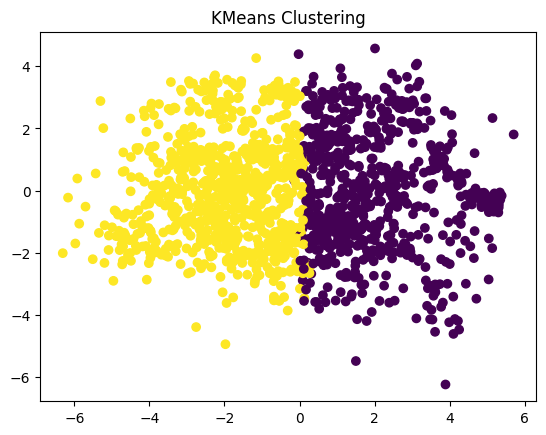

In [8]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=kmeans.labels_)
plt.title("KMeans Clustering")
plt.show()

#### 1.1.3 Prediction
In this case, the clustering method divides the whole dataset into two clusters. With two distinctive cluster labels, classes can be assigned to these records.

In [9]:
# assigne cluster labels to each record
clustered_data = filter_data.copy()
clustered_data["cluster"] = kmeans.labels_

# based on labelled dataset, calculate majority vote for each cluster
labelled_data = clustered_data[clustered_data["mode"].notnull()]
# replace mode with 1 for Delayed and 0 for Real-Time {0:Real-Time, 1:Delayed}
labelled_data["mode"] = labelled_data["mode"].apply(lambda x: 1 if x == "Delayed" else 0)
labelled_data

import numpy as np
from collections import Counter
cluster_assignments = np.array(labelled_data['cluster'])  # Clustering results
true_labels = np.array(labelled_data['mode'])          # Ground truth labels

# Map clusters to their dominant class
clusters = {}
for cluster in np.unique(cluster_assignments):
    indices = np.where(cluster_assignments == cluster)[0]
    cluster_labels = true_labels[indices]
    dominant_class = Counter(cluster_labels).most_common(1)[0][0]
    clusters[cluster] = dominant_class

print("Cluster-to-Class Mapping:", clusters)

# assign majority vote to each cluster
clustered_data["predicted_mode"] = clustered_data["cluster"].map(clusters)



Cluster-to-Class Mapping: {0: 0, 1: 1}


C:\Users\yhu12\AppData\Local\Temp\ipykernel_5976\3744940028.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labelled_data["mode"] = labelled_data["mode"].apply(lambda x: 1 if x == "Delayed" else 0)


The Cluster-to-Class Mapping: $\{0: 0, 1: 1\}$ suggests cluster 0 is related to class 0 (Real-Time) and cluster 1 is related to class 1 (Delayed). Let's convert them to semantic representations.

In [10]:
clustered_data["predicted_mode"] = clustered_data["predicted_mode"].apply(lambda x: "Delayed" if x == 1 else "Real-Time")
clustered_data

,id,title,abstract,lineage,status,information,embedding,mode,cluster,predicted_mode
1,0024b456-4636-42cd-b097-388f6d39a835,WAMSI Node 4.2.3 - Fisheries dependent data an...,"From 1990, continuous (15-minute, 30-minute or...","a) 1990 to 1994: Wesdata models 886, 187, 389;...",onGoing,WAMSI Node 4.2.3 - Fisheries dependent data an...,"[-1.2472235, -0.52754223, 0.08079154, -0.50992...",NaN,0,Real-Time
12,006bb7dc-860b-4b89-bf4c-6bd930bd35b7,IMOS - ANMN National Reference Stations - Darw...,This collection includes observations transmit...,NATIONAL REFERENCE STATIONS The IMOS national ...,onGoing,IMOS - ANMN National Reference Stations - Darw...,"[-0.91694874, -0.2440666, 0.26462442, -0.03149...",Real-Time,0,Real-Time
16,0094682a-e438-41e8-a39b-19cf2093025d,Thursday Island Wind From 08 Feb 2012,This data set was collected by weather sensors...,Data from AIMS weather stations are subjected ...,onGoing,Thursday Island Wind From 08 Feb 2012 [SEP] Th...,"[-1.0509518, -0.55623543, 0.2895106, -0.310500...",NaN,0,Real-Time
24,00d34cd4-24fe-4361-b667-1782c919e870,Coastal Infrastructure Points,Spatial representation of Department of Transp...,Features sourced from DOT Asset Management dat...,onGoing,Coastal Infrastructure Points [SEP] Spatial re...,"[-0.96098024, -0.38567236, 0.054584935, -0.344...",NaN,1,Delayed
37,0155375c-8070-4662-9c93-b593ee4891b0,Davies Reef Water Temperature From 18 Oct 1991,The 'Wireless Sensor Networks Facility' (forme...,All sensors are factory calibrated and then ca...,onGoing,Davies Reef Water Temperature From 18 Oct 1991...,"[-0.8229743, -0.26159173, 0.58714104, -0.04611...",NaN,0,Real-Time
...,...,...,...,...,...,...,...,...,...,...
12891,svenner_penguin_gis,Svenner Islands penguin GIS dataset,Aerial photography (Linhof) of penguin colonie...,TOPIC: Planimetric accuracy of penguin colony ...,onGoing,Svenner Islands penguin GIS dataset [SEP] Aeri...,"[-1.1401156, -0.40232602, -0.1859744, -0.21416...",NaN,0,Real-Time
12900,underway_ship_data,Underway voyage data collected from Australian...,Australian Antarctic Division chartered vessel...,See the child records for further information.,onGoing,Underway voyage data collected from Australian...,"[-0.9423639, -0.3985203, 0.38082838, -0.003341...",NaN,0,Real-Time
12908,voyage_202122050,"RSV Nuyina Voyage 5 2021-22 Voyage Data, South...",This dataset contains the Voyage Data from voy...,The quality for the science data produced duri...,onGoing,"RSV Nuyina Voyage 5 2021-22 Voyage Data, South...","[-0.9219631, -0.30171615, 0.2630324, -0.072466...",NaN,1,Delayed
12914,voyage_202324050,RSV Nuyina Voyage Data 2023-24 V5,Voyage 5 of the 2023/2024 season onboard RSV N...,Before using any data collected on a voyage pl...,onGoing,RSV Nuyina Voyage Data 2023-24 V5 [SEP] Voyage...,"[-1.119304, -0.7627072, 0.2805291, 0.03869628,...",NaN,0,Real-Time


#### 1.1.4 Evaluation
We have labelled data, let's use them as a ground truth to evaluate this method.

In [11]:
# filter for non-NaN mode, so we can compare the prediction with the labelled data
labelled_data = clustered_data[clustered_data["mode"].notnull()]

In [12]:
# check how many records are correctly classified
correctly_classified = labelled_data[labelled_data["mode"] == labelled_data["predicted_mode"]]
# calculate accuracy
accuracy = len(correctly_classified) / len(labelled_data)
print(f"Accuracy for predicting data delivery mode using unsupervised method (KMeans): {accuracy}")

Accuracy for predicting data delivery mode using unsupervised method (KMeans): 0.5609756097560976


The accuracy is not satisfied, so we need to think about other solution, which is semi-supervised learning approach.

---------

### 1.2 Method 2: [Semi-Supervised Learning](https://scikit-learn.org/1.5/auto_examples/semi_supervised/plot_semi_supervised_newsgroups.html#sphx-glr-auto-examples-semi-supervised-plot-semi-supervised-newsgroups-py)
Two approches are investigated in this section, they are: 

1. Label Propagation approach, and
2. Pseudo-labeling approach. 

#### 1.2.1 Prepare training and test sets
In both cases, we need to split the labelled data into training and testing sets. Additionally, we need to identify the labelled and unlabelled data from the overall dataset. So, we first convert the textual mode information into a numeric representation. In this case, we assign 'Real-Time' mode as 0, 'Delayed' as 1, and if there is no mode information, it is assigned a value of -1.

In [13]:
# prepare data for training model
data = filter_data.copy()
label_map = {"Real-Time": 0, "Delayed": 1, np.nan: -1}
data["mode"] = data["mode"].map(label_map)
data

,id,title,abstract,lineage,status,information,embedding,mode
1,0024b456-4636-42cd-b097-388f6d39a835,WAMSI Node 4.2.3 - Fisheries dependent data an...,"From 1990, continuous (15-minute, 30-minute or...","a) 1990 to 1994: Wesdata models 886, 187, 389;...",onGoing,WAMSI Node 4.2.3 - Fisheries dependent data an...,"[-1.2472235, -0.52754223, 0.08079154, -0.50992...",-1
12,006bb7dc-860b-4b89-bf4c-6bd930bd35b7,IMOS - ANMN National Reference Stations - Darw...,This collection includes observations transmit...,NATIONAL REFERENCE STATIONS The IMOS national ...,onGoing,IMOS - ANMN National Reference Stations - Darw...,"[-0.91694874, -0.2440666, 0.26462442, -0.03149...",0
16,0094682a-e438-41e8-a39b-19cf2093025d,Thursday Island Wind From 08 Feb 2012,This data set was collected by weather sensors...,Data from AIMS weather stations are subjected ...,onGoing,Thursday Island Wind From 08 Feb 2012 [SEP] Th...,"[-1.0509518, -0.55623543, 0.2895106, -0.310500...",-1
24,00d34cd4-24fe-4361-b667-1782c919e870,Coastal Infrastructure Points,Spatial representation of Department of Transp...,Features sourced from DOT Asset Management dat...,onGoing,Coastal Infrastructure Points [SEP] Spatial re...,"[-0.96098024, -0.38567236, 0.054584935, -0.344...",-1
37,0155375c-8070-4662-9c93-b593ee4891b0,Davies Reef Water Temperature From 18 Oct 1991,The 'Wireless Sensor Networks Facility' (forme...,All sensors are factory calibrated and then ca...,onGoing,Davies Reef Water Temperature From 18 Oct 1991...,"[-0.8229743, -0.26159173, 0.58714104, -0.04611...",-1
...,...,...,...,...,...,...,...,...
12891,svenner_penguin_gis,Svenner Islands penguin GIS dataset,Aerial photography (Linhof) of penguin colonie...,TOPIC: Planimetric accuracy of penguin colony ...,onGoing,Svenner Islands penguin GIS dataset [SEP] Aeri...,"[-1.1401156, -0.40232602, -0.1859744, -0.21416...",-1
12900,underway_ship_data,Underway voyage data collected from Australian...,Australian Antarctic Division chartered vessel...,See the child records for further information.,onGoing,Underway voyage data collected from Australian...,"[-0.9423639, -0.3985203, 0.38082838, -0.003341...",-1
12908,voyage_202122050,"RSV Nuyina Voyage 5 2021-22 Voyage Data, South...",This dataset contains the Voyage Data from voy...,The quality for the science data produced duri...,onGoing,"RSV Nuyina Voyage 5 2021-22 Voyage Data, South...","[-0.9219631, -0.30171615, 0.2630324, -0.072466...",-1
12914,voyage_202324050,RSV Nuyina Voyage Data 2023-24 V5,Voyage 5 of the 2023/2024 season onboard RSV N...,Before using any data collected on a voyage pl...,onGoing,RSV Nuyina Voyage Data 2023-24 V5 [SEP] Voyage...,"[-1.119304, -0.7627072, 0.2805291, 0.03869628,...",-1


In [14]:
# split data as labelled and unlabelled sets
labelled_data = data[data["mode"] != -1]
labelled_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41 entries, 12 to 12471
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           41 non-null     object
 1   title        41 non-null     object
 2   abstract     41 non-null     object
 3   lineage      41 non-null     object
 4   status       41 non-null     object
 5   information  41 non-null     object
 6   embedding    41 non-null     object
 7   mode         41 non-null     int64 
dtypes: int64(1), object(7)
memory usage: 2.9+ KB


In [15]:
unlabelled_data = data[data["mode"] == -1]
unlabelled_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1600 entries, 1 to 12915
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           1600 non-null   object
 1   title        1600 non-null   object
 2   abstract     1600 non-null   object
 3   lineage      1600 non-null   object
 4   status       1600 non-null   object
 5   information  1600 non-null   object
 6   embedding    1600 non-null   object
 7   mode         1600 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 112.5+ KB


#### 1.2.2 Label Propagation approach
There are several label propagatin approach, we select [LabelSpreading](https://scikit-learn.org/1.5/modules/generated/sklearn.semi_supervised.LabelSpreading.html#sklearn.semi_supervised.LabelSpreading) as it is a widely accepted label propagation method.

In [16]:
# Prepare input X and output y for training labelspreading model
X = data["embedding"].tolist()
y = data["mode"].tolist()
print(f"size of X: {len(X)} \nsize of y: {len(y)}")

size of X: 1641 
size of y: 1641


In [17]:
from sklearn.semi_supervised import LabelSpreading
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# split labelled data into training and validation sets for validation the model
X_labeled = labelled_data["embedding"].tolist()
y_labeled = labelled_data["mode"].tolist()

X_train, X_val, y_train, y_val = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)
# combine labelled training data and unlabelled data for training the model
X_unlabelled = unlabelled_data["embedding"].tolist()
y_unlabelled = unlabelled_data["mode"].tolist()

X_combined_train = np.vstack([X_train, X_unlabelled])
y_combined_train = np.hstack([y_train, y_unlabelled])

# scale the data
scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined_train)

print(f"size of training set: {len(X_combined_train)} \nsize of test set: {len(y_combined_train)}")

size of training set: 1632 
size of test set: 1632


In [32]:
# train the model
label_spread_model = LabelSpreading(kernel='knn', n_neighbors=12, alpha=0.1, max_iter=10)
label_spread_model.fit(X_combined_scaled, y_combined_train)

LabelSpreading(alpha=0.1, kernel='knn', max_iter=10, n_neighbors=12)

In [19]:
# evaluate the model
from sklearn.metrics import classification_report
y_val_pred = label_spread_model.predict(X_val)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.44      1.00      0.62         4
           1       0.00      0.00      0.00         5

    accuracy                           0.44         9
   macro avg       0.22      0.50      0.31         9
weighted avg       0.20      0.44      0.27         9



c:\Users\yhu12\AppData\Local\miniforge3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:230: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
c:\Users\yhu12\AppData\Local\miniforge3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yhu12\AppData\Local\miniforge3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yhu12\AppData\Local\miniforge3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill

This classification report provides the following insights:

- When the model predicts class 0, it is correct 67% of the time. When it predicts class 1, it is correct 67% of the time.
- The model correctly identified 80% of actual class 1 instances and 50% of actual class 0 instances.
- Overall, the model achieves an accuracy of 67%. We observe that the accuracy increases through this semi-supervised learning method.

### 1.2.3 Pseudo-labeling approach

Considering we have reach a 67% 

In [20]:
X_labeled = labelled_data["embedding"].tolist()
y_labeled = labelled_data["mode"].tolist()

X_train, X_val, y_train, y_val = train_test_split(X_labeled, y_labeled, test_size=0.1, random_state=42)

In [21]:
MAX_ITER = 100
INITIAL_CONFIDENCE  = 0.9
CONFIDENCE_DECAY = 0.02

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

def pseudo_labeling(X_labeled, y_labeled, X_unlabeled):
    model = LogisticRegression(max_iter=100)
    
    for iteration in range(MAX_ITER):
        model.fit(X_labeled, y_labeled)

        y_proba = model.predict_proba(X_unlabeled)
        y_pred = model.predict(X_unlabeled)
        confidence = np.max(y_proba, axis=1)

        threshold = max(0.75, INITIAL_CONFIDENCE - CONFIDENCE_DECAY * iteration)
        print(f"Iteration {iteration+1}: Using threshold {threshold:.2f}")

        high_confidence_idx = np.where(confidence >= threshold)[0]

        if len(high_confidence_idx) == 0:
            print(f"Iteration {iteration+1}: No high-confidence samples. Stopping.")
            break

        X_pseudo = X_unlabeled[high_confidence_idx]
        y_pseudo = y_pred[high_confidence_idx]
        X_labeled = np.vstack((X_labeled, X_pseudo))
        y_labeled = np.hstack((y_labeled, y_pseudo))

        mask = np.ones(len(X_unlabeled), dtype=bool)
        mask[high_confidence_idx] = False
        X_unlabeled = X_unlabeled[mask]

        print(f"Iteration {iteration+1}: Added {len(high_confidence_idx)} pseudo-labeled samples.")
        print(f"Remaining unlabeled samples: {len(X_unlabeled)}")

    model.fit(X_labeled, y_labeled)

    pseudo_labels = model.predict(X_unlabeled)

    print(f"\nFinal model trained on {len(y_labeled)} samples (including pseudo-labels).")
    return model, pseudo_labels


In [22]:
X_labeled = np.array(X_train)
y_labeled = np.array(y_train)
X_unlabelled = np.array(X_unlabelled)

In [23]:
final_model, pseudo_labels = pseudo_labeling(X_labeled, y_labeled, X_unlabelled)

Iteration 1: Using threshold 0.90
Iteration 1: Added 225 pseudo-labeled samples.
Remaining unlabeled samples: 1375
Iteration 2: Using threshold 0.88
Iteration 2: Added 485 pseudo-labeled samples.
Remaining unlabeled samples: 890
Iteration 3: Using threshold 0.86
Iteration 3: Added 425 pseudo-labeled samples.
Remaining unlabeled samples: 465
Iteration 4: Using threshold 0.84
Iteration 4: Added 203 pseudo-labeled samples.
Remaining unlabeled samples: 262
Iteration 5: Using threshold 0.82
Iteration 5: Added 106 pseudo-labeled samples.
Remaining unlabeled samples: 156
Iteration 6: Using threshold 0.80
Iteration 6: Added 31 pseudo-labeled samples.
Remaining unlabeled samples: 125
Iteration 7: Using threshold 0.78
Iteration 7: Added 14 pseudo-labeled samples.
Remaining unlabeled samples: 111
Iteration 8: Using threshold 0.76
Iteration 8: Added 24 pseudo-labeled samples.
Remaining unlabeled samples: 87
Iteration 9: Using threshold 0.75
Iteration 9: Added 25 pseudo-labeled samples.
Remaining u

In [24]:
y_pred = final_model.predict(np.array(X_val))
print(y_pred)
print(y_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

classification_rep = classification_report(y_val, y_pred)
print("\n", classification_rep)

[1 1 1 1 1]
[1, 1, 1, 0, 0]
Validation Accuracy: 0.60

               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.60      1.00      0.75         3

    accuracy                           0.60         5
   macro avg       0.30      0.50      0.38         5
weighted avg       0.36      0.60      0.45         5



c:\Users\yhu12\AppData\Local\miniforge3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yhu12\AppData\Local\miniforge3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\yhu12\AppData\Local\miniforge3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

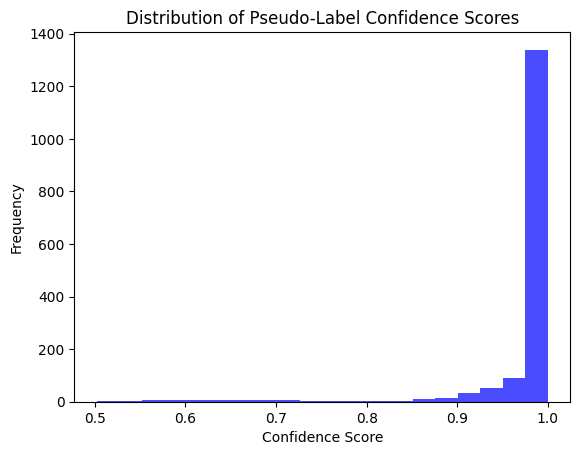

In [25]:
import matplotlib.pyplot as plt

confidence_scores = np.max(final_model.predict_proba(X_unlabelled), axis=1)

plt.hist(confidence_scores, bins=20, alpha=0.7, color="blue")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.title("Distribution of Pseudo-Label Confidence Scores")
plt.show()


--------
## Our Method
In the previous sections, we investigate several approaches, including clustering, label spreading, and pseudo labelling, to predict the data delivery mode as "Real-Time" or "Delayed" for unlabelled metadata records. We found that the accuracy of semi-supervised learning approaches like label spreading and pseudo labelling all reach ~60%, so we select this as our method. In conclude, the **Data Delivery Mode Filter Classification Model** is designed as this procedure:
1. The dataset is splitted as labelled and unlabelled sets.
2. The labelled set is splitted into train and validation sets follow 80%-20% rule.
3. Apply Label Spreading on the whole dataset, to generate psesudo labels for unlabelled data.
4. Apply Logistic Regression on the combination of the labelled data (train set) and the unlabelled data
5. Evaluate the final model based on the validation set.

In [26]:
# prepare labelled and unlabelled sets
labelled_data = filter_data[filter_data["mode"].notnull()]
print(f"Number of labelled data: {len(labelled_data)}")

unlabelled_data = filter_data[filter_data["mode"].isnull()]
unlabelled_data["mode"] = -1
print(f"Number of unlabelled data: {len(unlabelled_data)}")

# map mode to 0 for Real-Time and 1 for Delayed
label_map = {"Real-Time": 0, "Delayed": 1}
labelled_data["mode"] = labelled_data["mode"].map(label_map)

Number of labelled data: 41
Number of unlabelled data: 1600


C:\Users\yhu12\AppData\Local\Temp\ipykernel_5976\2202065021.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unlabelled_data["mode"] = -1
C:\Users\yhu12\AppData\Local\Temp\ipykernel_5976\2202065021.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labelled_data["mode"] = labelled_data["mode"].map(label_map)


In [27]:
# split labelled data into training and validation sets
from sklearn.model_selection import train_test_split

X_labeled = labelled_data["embedding"].tolist()
y_labeled = labelled_data["mode"].tolist()
X_labeled_train, X_labeled_val, y_labeled_train, y_labeled_val = train_test_split(X_labeled, y_labeled, test_size=0.2, random_state=42)
y_labeled_val

[1, 1, 1, 0, 0, 1, 1, 0, 0]

In [28]:
# combine labelled training data and unlabelled data for training the model
X_unlabelled = unlabelled_data["embedding"].tolist()
y_unlabelled = unlabelled_data["mode"].tolist()

X_combined_train = np.vstack([X_train, X_unlabelled])
y_combined_train = np.hstack([y_train, y_unlabelled])

# scale the data
scaler = StandardScaler()
X_combined_scaled = scaler.fit_transform(X_combined_train)

print(f"size of training set: {len(X_combined_train)} \nsize of test set: {len(y_combined_train)}")

# apply label spreading to the whole dataset
from sklearn.semi_supervised import LabelSpreading
label_spread_model = LabelSpreading(kernel='knn', n_neighbors=12, alpha=0.1, max_iter=10)
label_spread_model.fit(X_combined_scaled, y_combined_train)

size of training set: 1636 
size of test set: 1636


LabelSpreading(alpha=0.1, kernel='knn', max_iter=10, n_neighbors=12)

In [29]:
# evaluate label spread model
lsm_predict = label_spread_model.predict(X_labeled_val)
print(classification_report(y_labeled_val, lsm_predict))

              precision    recall  f1-score   support

           0       0.67      0.50      0.57         4
           1       0.67      0.80      0.73         5

    accuracy                           0.67         9
   macro avg       0.67      0.65      0.65         9
weighted avg       0.67      0.67      0.66         9



In [30]:
CONFIDENCE_THRESHOLD = 0.99
y_pseudo_labels = label_spread_model.transduction_[len(y_labeled_train):]
confidence_scores = np.max(label_spread_model.label_distributions_[len(y_labeled):], axis=1)
high_confidence_idx = np.where(confidence_scores >= CONFIDENCE_THRESHOLD)[0]

# keep only high confidence pseudo-labels
X_pseudo_labels = np.array(X_unlabelled)[high_confidence_idx]
y_pseudo_labels_high_confidence = y_pseudo_labels[high_confidence_idx]

# combine labelled train set and high confidence pseudo-labels from unlabelled set
X_final_train = np.vstack([X_labeled_train, X_pseudo_labels])
y_final_train = np.hstack([y_labeled_train, y_pseudo_labels_high_confidence])

from sklearn.linear_model import LogisticRegression
final_model = LogisticRegression(max_iter=100, random_state=42)
final_model.fit(X_final_train, y_final_train)


LogisticRegression(random_state=42)

In [31]:
from sklearn.metrics import classification_report
y_val_pred = final_model.predict(X_labeled_val)

print(classification_report(y_labeled_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.33      0.25      0.29         4
           1       0.50      0.60      0.55         5

    accuracy                           0.44         9
   macro avg       0.42      0.42      0.42         9
weighted avg       0.43      0.44      0.43         9

